In [1]:
import numpy as np
import gzip
import theano
from keras.models import load_model
from keras.models import Model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def get_test():
    
    f = open('datasetTranskay/cb513+profile_split1.npy.gz', 'rb')
    cb513 = np.load(f)
    cb513 = np.reshape(cb513, (514, 700, 57))
    cb513 = cb513[:, :, :].astype(theano.config.floatX)

    return cb513

In [3]:
cb513 = get_test()

In [ ]:
for i in range(700):
    print(cb513[0,i,0:21])
    print(cb513[0,i,22:30])
    if(cb513[0,i,0:21].sum() == 0):
        print(i)
    if(cb513[0,i,22:30].sum() == 0):
        print(i)        

In [ ]:
path = "model-assmebly-11.hdf5"
m = load_model( path )

In [4]:
from IPython.display import clear_output
import random

allValidWindows = []
all_targets = []

for i in range(cb513.shape[0]):
    
    print("protein nr " ,i)
    clear_output(wait=True)
    
    lastIndex = 700
    #ground truth
    for k in range(700):
        ground_truth = cb513[i,k,22:30]
        if(ground_truth.sum() == 0):
            lastIndex = k
            break
        all_targets.append(ground_truth)

    #creating padding version so we do not loose information
    padded = np.zeros((700+18, 57))
    padded[9:709] = cb513[i]
    
    for k in range(9):
        #padded[8-k] = cb513[i, lastIndex - 1 - k]
        padded[k] = cb513[i,0]#cb513[i,random.randint(0, lastIndex - 1)]#  #0# #
    
    nexta = 0
    for k in range(lastIndex + 9 , lastIndex + 9 + 9):
        #padded[k] = 0# cb513[i, 0 + nexta]
        nexta += 1
        padded[k] = 0#cb513[i,random.randint(0, lastIndex - 1)]#cb513[i,lastIndex - 1]##
        
    
    #making predictions
    predictions = []
    for k in range(718 - 19 + 1):

        if cb513[i,k,0:21].sum() == 0:
            break
        #make sure to check PSSM or 1 hot
        window =  padded[k:k+19, 35:56]
        allValidWindows.append(window)

protein nr  513


In [ ]:
scores = m.evaluate(np.array(allValidWindows), np.array(all_targets))
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))

In [ ]:
for i in range(718):
    if i<9:
        print(padded[i,0:21])
    
    if i >= 9 and i <= 708:
        print(padded[i,0:21].all() == cb513[0,i-9,0:21].all())
    
    if i > 708:
        print(padded[i,0:21])

In [ ]:
print(len(allValidWindows))

In [ ]:
x = np.array(allValidWindows)

In [ ]:
for i in range(19):
    print(x[66][i][0])

33   0.6996637763255874


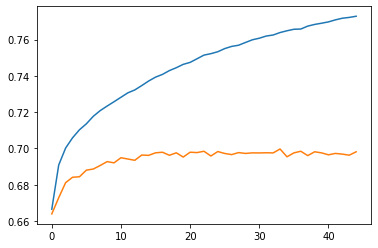

In [51]:
import matplotlib.pyplot as plt
import pickle

m1H1 = pickle.load( open( "saved-models/best-assmebly-history-5", "rb" ) )
# Plot training & validation accuracy values


a = np.array(m1H1['val_acc'])
inde = np.argmax(a)
x = m1H1['val_acc'][inde]
print(inde, " ", x)


plt.plot(m1H1['acc'])
plt.plot(m1H1['val_acc'])


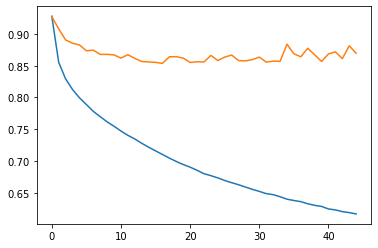

In [52]:
plt.plot(m1H1['loss'])
plt.plot(m1H1['val_loss'])

In [19]:
## model assembly cb513 accuracy
def get_stacked_predictions(allValidWindows, nr_models):
    
    stacked_predictions = []
    for i in range (nr_models):
    
        path = 'model-assmebly-' + str(i) + '.hdf5'
        m = load_model( path )
        print("model " , i)
        predictions  = m.predict(allValidWindows, verbose = 1)
        stacked_predictions.append(predictions)
    
    return np.array(stacked_predictions)

nr_models = 10
stacked_predictions = get_stacked_predictions(allValidWindows, nr_models)

model  0
84765/84765 [==============================] - 50s 585us/step
model  1
84765/84765 [==============================] - 53s 620us/step
model  2
84765/84765 [==============================] - 51s 606us/step
model  3
84765/84765 [==============================] - 52s 609us/step
model  4
84765/84765 [==============================] - 51s 601us/step
model  5
84765/84765 [==============================] - 51s 602us/step
model  6
84765/84765 [==============================] - 52s 615us/step
model  7
84765/84765 [==============================] - 62s 734us/step
model  8
84765/84765 [==============================] - 67s 786us/step
model  9
84765/84765 [==============================] - 64s 752us/step


In [36]:
def sum_predictions(window_preds):
    return sum(window_preds, 0)
def average_predictions(window_preds):
    return np.average(window_preds, 0)
def max_predictions(window_preds):
    return np.max(window_preds, 0)

In [37]:
assembly_pred = []    
for i in range(allValidWindows.shape[0]):

    print("window nr " ,i)
    clear_output(wait=True)
    
    window_preds = stacked_predictions[:,i]
    window_pred = max_predictions(window_preds)
    assembly_pred.append(window_pred)
    
assembly_pred = np.array(assembly_pred)    

window nr  84764


In [38]:
all_targets = np.array(all_targets)

final_pred = []
final_target = []
for i in range(len(allValidWindows)):
    final_pred.append( np.argmax(assembly_pred[i]))
    final_target.append( np.argmax(all_targets[i]))

In [39]:
from sklearn.metrics import accuracy_score

accuracy_score(final_pred, np.array(final_target))

0.7070960891877544

In [35]:
a = np.array([[5,2,3], [5,6,7]])
print(a.shape)

c = np.max(a, 0)
print(c)

(2, 3)
[5 6 7]
